In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import json
import ast
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define a function that loads json columns in movies dataset
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

#define a function that loads json columns in credits dataset
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


In [3]:
#load datasets
movies = load_tmdb_movies("tmdb_5000_movies.csv")
credits = load_tmdb_credits("tmdb_5000_credits.csv")

## ASSESSING DATA QUALITY

In [4]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [5]:
print(f'The movies data contains {movies.shape[0]} rows and {movies.shape[1]} columns')

The movies data contains 4803 rows and 20 columns


In [6]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


There are some irregularites in the data.Some coloumns have a minimum value of zero, which is highly unlikely. For instance, it is impossible for a movie to have $0 budget. 
Also, the disperity in popularity is high, considering the mean value and the maximum value. This suggests outliers in the column. 

In [7]:
#from pandas_profiling import ProfileReport
#prof = ProfileReport(movies)

In [8]:
#prof

### Data Assesment Issues From Profile Report
* JSON ENTRIES 
* Budget has 21.6% zeros 
* release_date has missing values
* runtime has missing values 
* revenue has 29.7% zeros !
* vote average has 1.3% zeros 
* vote count has 1.3% zeros 

In [9]:
# info on variable types and filling factor
tab_info=pd.DataFrame(movies.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(movies.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(movies.isnull().sum()/movies.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64
null values,0,0,3091,0,0,0,0,3,0,0,0,1,0,2,0,0,844,0,0,0
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0


In [10]:
movies.shape

(4803, 20)

## Dealing with json Entries

#### Some functions that will come handy during data wrangling

In [11]:
def extract_feature(x, field='name'):
    """
    function is intended extract values of a specified field
    as a list...
    """
    return [i[field] for i in x]

def find_index_val(x, idx=0):
    """
    Function would come in handy when
    I am trying to find primary genre for example..
    """
    return x[idx] if len(x) > 0 else np.NAN

def cal_length(x):
    return len(x)

def find_role(x, role='Director'):
    for i in x:
        if i['job'] == role:
            return i['name']
    return np.NaN

def find_animation(x):
    for i in x:
        if i.lower() == 'animation':
            return 1
    return 0

def get_lengths(x):
    return len(x)

def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan # return missing value rather than an error upon indexing/key failure

In [12]:
#get the genre list for each movie
movies['list_genres'] = movies['genres'].apply(extract_feature)

In [13]:
movies['list_genres']

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4798                        [Action, Crime, Thriller]
4799                                [Comedy, Romance]
4800               [Comedy, Drama, Romance, TV Movie]
4801                                               []
4802                                    [Documentary]
Name: list_genres, Length: 4803, dtype: object

In [14]:
#Apply the functions to extract some useful features from the dataset
movies['primary_genre'] = movies['list_genres'].apply(find_index_val)

movies['list_keywords'] = movies['keywords'].apply(extract_feature)

movies['list_production_companies'] = movies['production_companies'].apply(extract_feature)

movies['num_production_companies'] = movies['list_production_companies'].apply(cal_length)

movies['list_productioin_countries'] = movies['production_countries'].apply(extract_feature)

movies['num_productioin_countries'] = movies['list_productioin_countries'].apply(cal_length)

movies['list_spoken_languages'] = movies['spoken_languages'].apply(extract_feature)

movies['num_spoken_languages'] = movies['list_spoken_languages'].apply(cal_length)

movies['animated'] = movies['list_genres'].apply(find_animation)

In [15]:
movie_features = ['id', 'original_title', 'budget', 'revenue', 'original_language', 'status', 
                  'release_date', 'overview', 'tagline', 'list_keywords', 'primary_genre', 'list_genres', 
                  'list_productioin_countries', 'num_production_companies', 
                  'num_productioin_countries', 'list_spoken_languages', 'num_spoken_languages', 'popularity', 
                  'vote_average', 'vote_count', 'runtime', 'animated']

In [16]:
movie_final = movies[movie_features].copy()

movie_final.head()

,id,original_title,budget,revenue,original_language,status,release_date,overview,tagline,list_keywords,...,list_productioin_countries,num_production_companies,num_productioin_countries,list_spoken_languages,num_spoken_languages,popularity,vote_average,vote_count,runtime,animated
0,19995,Avatar,237000000,2787965087,en,Released,2009-12-10,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",...,"[United States of America, United Kingdom]",4,2,"[English, Español]",2,150.437577,7.2,11800,162.0,0
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,en,Released,2007-05-19,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",...,[United States of America],3,1,[English],1,139.082615,6.9,4500,169.0,0
2,206647,Spectre,245000000,880674609,en,Released,2015-10-26,A cryptic message from Bond’s past sends him o...,A Plan No One Escapes,"[spy, based on novel, secret agent, sequel, mi...",...,"[United Kingdom, United States of America]",3,2,"[Français, English, Español, Italiano, Deutsch]",5,107.376788,6.3,4466,148.0,0
3,49026,The Dark Knight Rises,250000000,1084939099,en,Released,2012-07-16,Following the death of District Attorney Harve...,The Legend Ends,"[dc comics, crime fighter, terrorist, secret i...",...,[United States of America],4,1,[English],1,112.312950,7.6,9106,165.0,0
4,49529,John Carter,260000000,284139100,en,Released,2012-03-07,"John Carter is a war-weary, former military ca...","Lost in our world, found in another.","[based on novel, mars, medallion, space travel...",...,[United States of America],1,1,[English],1,43.926995,6.1,2124,132.0,0


In [17]:
movie_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4803.0,5.716548e+04,8.869461e+04,5.0,9014.50000,1.462900e+04,5.861050e+04,4.594880e+05
budget,4803.0,2.904504e+07,4.072239e+07,0.0,790000.00000,1.500000e+07,4.000000e+07,3.800000e+08
revenue,4803.0,8.226064e+07,1.628571e+08,0.0,0.00000,1.917000e+07,9.291719e+07,2.787965e+09
num_production_companies,4803.0,2.847595e+00,2.231894e+00,0.0,1.00000,2.000000e+00,4.000000e+00,2.600000e+01
num_productioin_countries,4803.0,1.339996e+00,7.992847e-01,0.0,1.00000,1.000000e+00,2.000000e+00,1.200000e+01
num_spoken_languages,4803.0,1.444306e+00,9.269274e-01,0.0,1.00000,1.000000e+00,2.000000e+00,9.000000e+00
popularity,4803.0,2.149230e+01,3.181665e+01,0.0,4.66807,1.292159e+01,2.831350e+01,8.755813e+02
vote_average,4803.0,6.092172e+00,1.194612e+00,0.0,5.60000,6.200000e+00,6.800000e+00,1.000000e+01
vote_count,4803.0,6.902180e+02,1.234586e+03,0.0,54.00000,2.350000e+02,7.370000e+02,1.375200e+04
runtime,4801.0,1.068759e+02,2.261193e+01,0.0,94.00000,1.030000e+02,1.180000e+02,3.380000e+02


In [18]:
credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."


In [19]:
credits['movie_director'] = credits['crew'].apply(find_role, role='Director')
credits['crew_size'] = credits['crew'].apply(get_lengths)
credits['cast_size'] = credits['cast'].apply(get_lengths)


In [20]:
credit_features = ['movie_id', 'title', 'movie_director', 'crew_size', 'cast_size']

In [21]:
credit_final = credits[credit_features].copy()

In [22]:
credit_final.head()

,movie_id,title,movie_director,crew_size,cast_size
0,19995,Avatar,James Cameron,153,83
1,285,Pirates of the Caribbean: At World's End,Gore Verbinski,32,34
2,206647,Spectre,Sam Mendes,155,83
3,49026,The Dark Knight Rises,Christopher Nolan,217,158
4,49529,John Carter,Andrew Stanton,132,27


In [23]:
credits.apply(lambda row: [x.update({'movie_id': row['movie_id']}) for x in row['cast']], axis=1)
credits.apply(lambda row: [x.update({'movie_id': row['movie_id']}) for x in row['crew']], axis=1)
credits.apply(lambda row: [person.update({'order': order}) for order, person in enumerate(row['crew'])], axis=1)

cast_list = []
credits["cast"].apply(lambda x: cast_list.extend(x))
cast = pd.DataFrame(cast_list)
cast["type"] = "cast"

crew_list = []
credits["crew"].apply(lambda x: crew_list.extend(x))
crew = pd.DataFrame(crew_list)
crew["type"] = "crew"

people = pd.concat([cast, crew], ignore_index=True, sort=True)

In [24]:
df = pd.merge(movie_final,credit_final, left_on='id', right_on='movie_id')


In [25]:
df.head(3)

,id,original_title,budget,revenue,original_language,status,release_date,overview,tagline,list_keywords,...,popularity,vote_average,vote_count,runtime,animated,movie_id,title,movie_director,crew_size,cast_size
0,19995,Avatar,237000000,2787965087,en,Released,2009-12-10,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",...,150.437577,7.2,11800,162.0,0,19995,Avatar,James Cameron,153,83
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,en,Released,2007-05-19,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",...,139.082615,6.9,4500,169.0,0,285,Pirates of the Caribbean: At World's End,Gore Verbinski,32,34
2,206647,Spectre,245000000,880674609,en,Released,2015-10-26,A cryptic message from Bond’s past sends him o...,A Plan No One Escapes,"[spy, based on novel, secret agent, sequel, mi...",...,107.376788,6.3,4466,148.0,0,206647,Spectre,Sam Mendes,155,83


In [26]:
df.columns

Index(['id', 'original_title', 'budget', 'revenue', 'original_language',
       'status', 'release_date', 'overview', 'tagline', 'list_keywords',
       'primary_genre', 'list_genres', 'list_productioin_countries',
       'num_production_companies', 'num_productioin_countries',
       'list_spoken_languages', 'num_spoken_languages', 'popularity',
       'vote_average', 'vote_count', 'runtime', 'animated', 'movie_id',
       'title', 'movie_director', 'crew_size', 'cast_size'],
      dtype='object')

## Dealing with zero values, missing runtime data

In [27]:
#Replace all the zero values in the following columns with their respective mean values
df['revenue'] = df['revenue'].replace(0, np.nan).fillna(df['revenue'].mean())
df['budget'] = df['budget'].replace(0,np.nan).fillna(df['budget'].mean())
df['vote_count'] = df['vote_count'].replace(0, np.nan).fillna(df['vote_count'].mean())
df['vote_average'] = df['vote_average'].replace(0, np.nan).fillna(df['vote_average'].mean())

In [28]:
#fill missing 'runtime' values with mean.
df['runtime']=df['runtime'].replace(0, np.nan).fillna(df['runtime'].mean())

## Dealing with datetime values

In [29]:
df["release_date"] = pd.to_datetime(df["release_date"]) #convert release date to datetime
df["release_year"] =df["release_date"].dt.year #extract release year
df["release_month"] = df["release_date"].dt.month  #extract release month
df["release_quarter"] = df["release_date"].dt.quarter #extract release quarter

## DATA ANALYSIS AND VISUALIZATION

### General Distirbution of Numerical Values

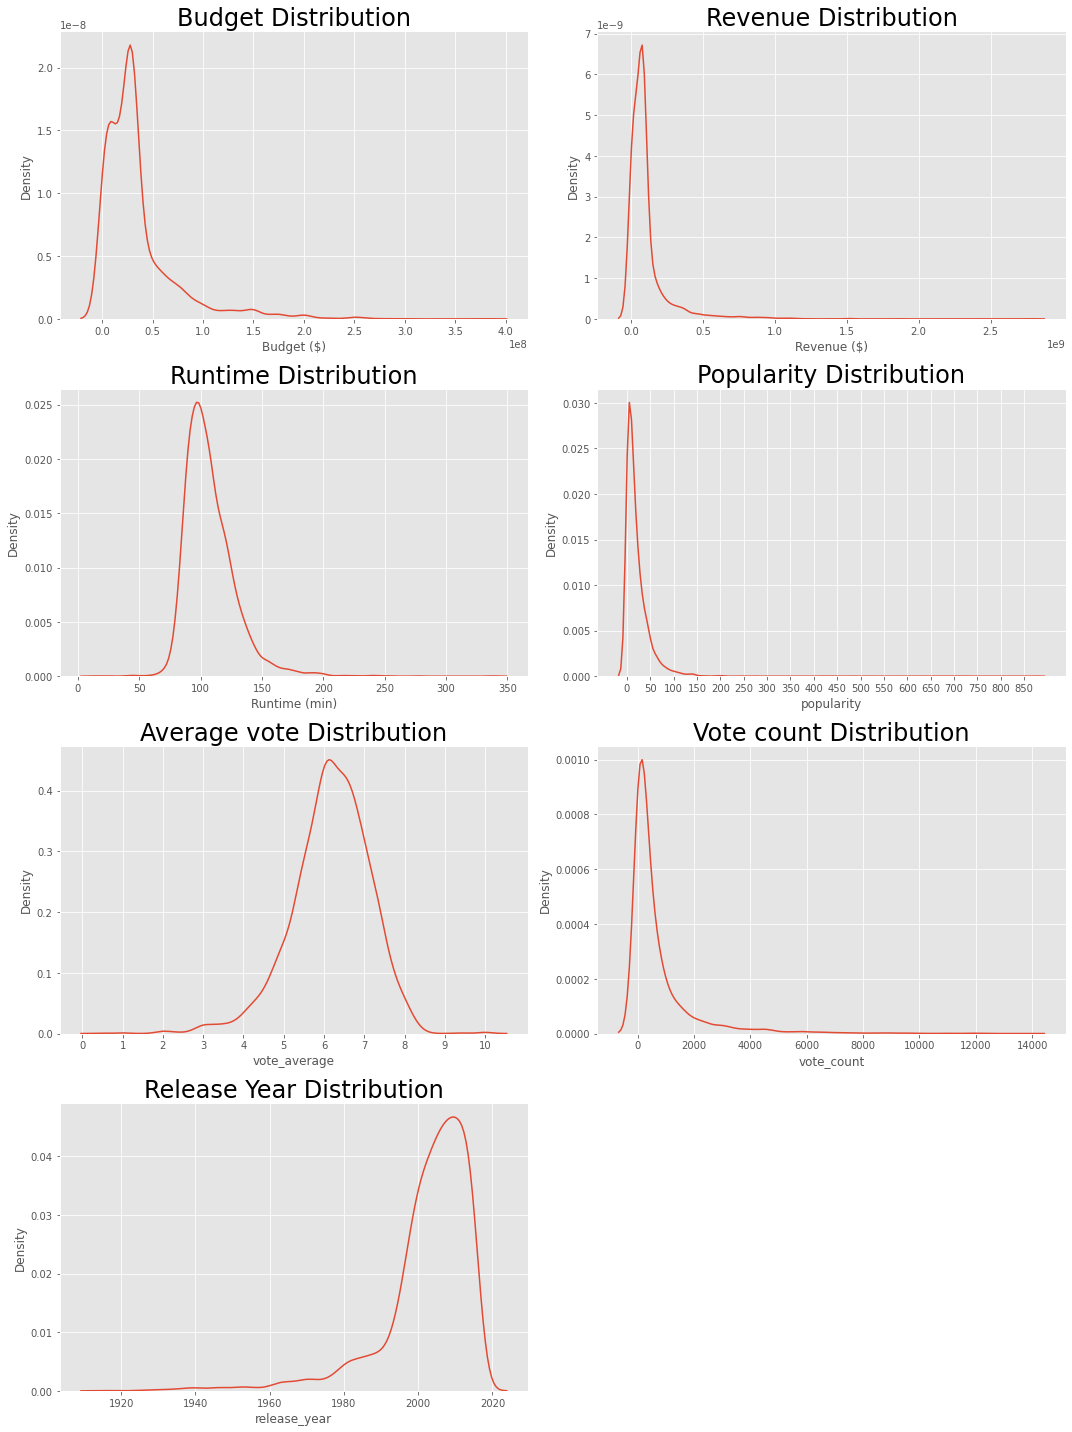

In [30]:
#Initiate KDE subplots for numerical columns
fig, axarr = plt.subplots(4, 2, figsize=(15, 20))
sns.kdeplot(df["budget"], ax=axarr[0][0])
axarr[0][0].xaxis.set_ticks(np.arange(0, 4.25e8, 0.50e8))

sns.kdeplot(df["revenue"], ax=axarr[0][1])
axarr[0][1].xaxis.set_ticks(np.arange(0, 3e9, 0.50e9))
sns.kdeplot(df["runtime"], ax=axarr[1][0])

sns.kdeplot(df["popularity"], ax=axarr[1][1])
axarr[1][1].xaxis.set_ticks(np.arange(0, 900, 50))

sns.kdeplot(df["vote_average"], ax=axarr[2][0])
axarr[2][0].xaxis.set_ticks(np.arange(0, 11, 1))

sns.kdeplot(df["vote_count"], ax=axarr[2][1])
sns.kdeplot(df["release_year"], ax=axarr[3][0])

axarr[3][1].axis("off")

#set subplot titles
axarr[0][0].set_title('Budget Distribution', fontsize = 24)
axarr[0][1].set_title('Revenue Distribution', fontsize = 24)
axarr[1][0].set_title('Runtime Distribution', fontsize = 24)
axarr[1][1].set_title('Popularity Distribution', fontsize = 24)
axarr[2][0].set_title('Average vote Distribution', fontsize = 24)
axarr[2][1].set_title('Vote count Distribution', fontsize = 24)
axarr[3][0].set_title('Release Year Distribution', fontsize = 24)

axarr[0][0].set_xlabel('Budget ($)', fontsize = 12)
axarr[0][1].set_xlabel('Revenue ($)', fontsize = 12)
axarr[1][0].set_xlabel('Runtime (min)', fontsize = 12)

fig.tight_layout()

From the results above, we can see that most films in our dataset have a budget of less than 10 million and a grossed revenue of less than 100 million. We can also see that most films have a runtime of around 100 minutes or 1 hour and 45 minutes. In terms of film acclaim and recognition in our dataset, we can see that most films have a popularity score around 20, with a vote average score usually between 6.0 and 7.0, and a vote count numbering less than 500. 

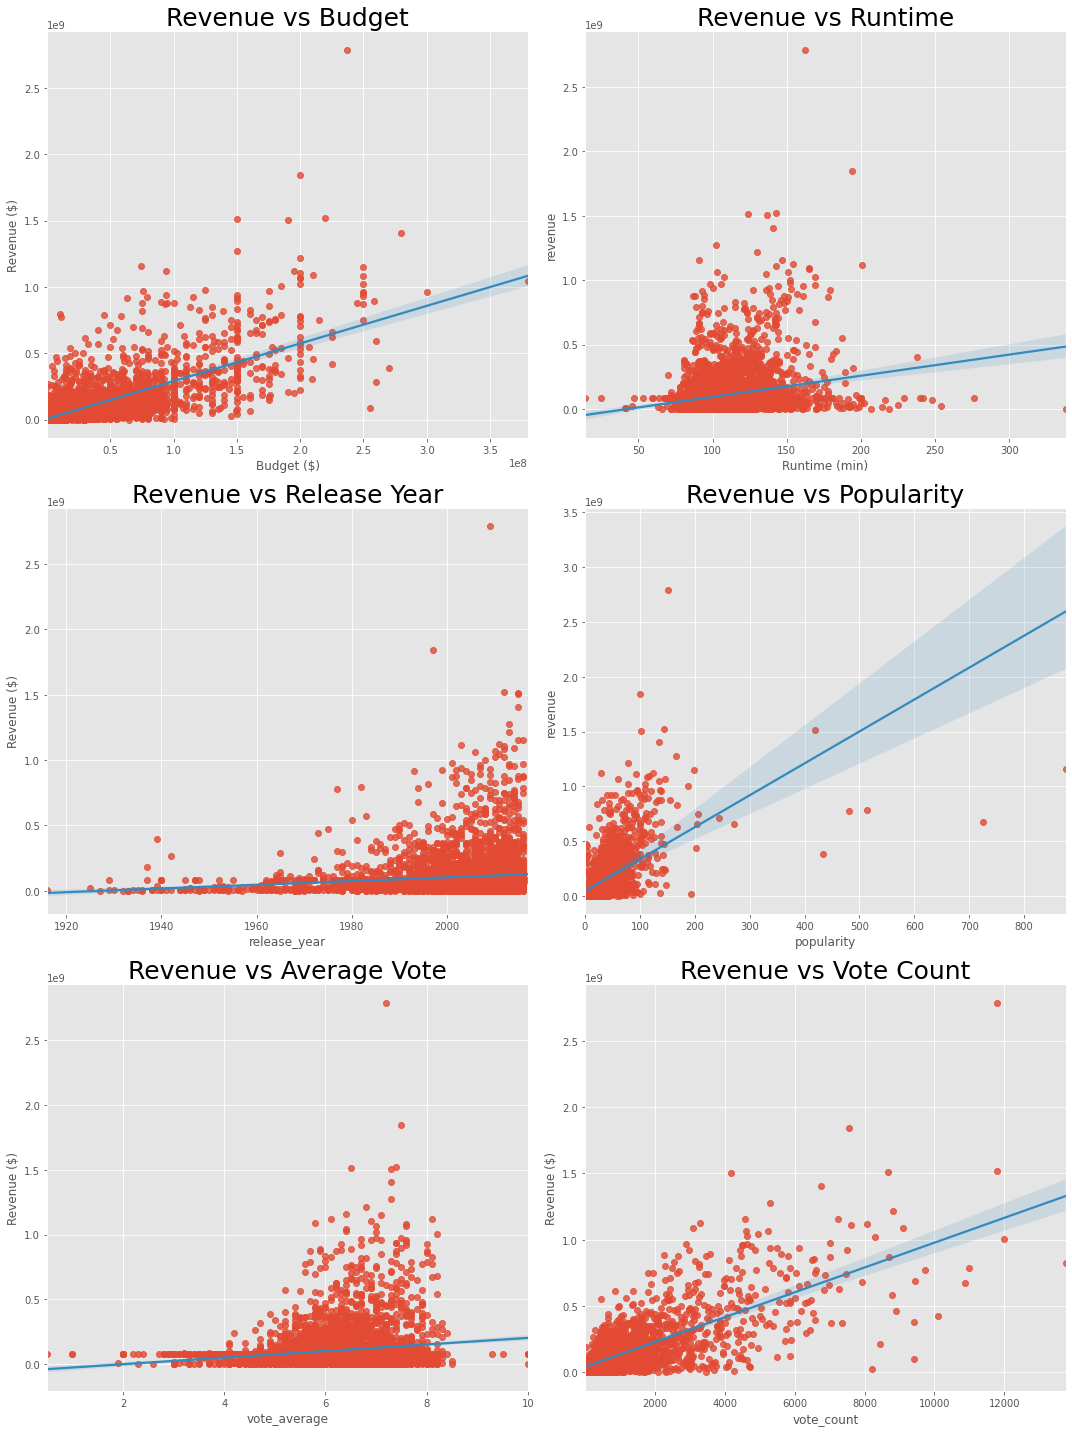

In [31]:
# Innitiate scatter plots with correlation lines
fig, axarr = plt.subplots(3, 2, figsize=(15, 20))
p_color = dict(color="C0")
l_color = dict(color="C1")
sns.regplot(x="budget", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[0][0])
sns.regplot(x="runtime", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[0][1])
sns.regplot(x="release_year", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[1][0])
sns.regplot(x="popularity", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[1][1])
sns.regplot(x="vote_average", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[2][0])
sns.regplot(x="vote_count", y="revenue", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[2][1])

axarr[0][0].set_xlabel('Budget ($)', fontsize = 12)
axarr[0][0].set_ylabel('Revenue ($)', fontsize = 12)
axarr[0][1].set_xlabel('Runtime (min)', fontsize = 12)
axarr[1][0].set_ylabel('Revenue ($)', fontsize = 12)
axarr[2][0].set_ylabel('Revenue ($)', fontsize = 12)
axarr[2][1].set_ylabel('Revenue ($)', fontsize = 12)

#Set plot titles
axarr[0][0].set_title('Revenue vs Budget', fontsize = 25)
axarr[0][1].set_title('Revenue vs Runtime', fontsize = 25)
axarr[1][0].set_title('Revenue vs Release Year', fontsize = 25)
axarr[1][1].set_title('Revenue vs Popularity', fontsize = 25)
axarr[2][0].set_title('Revenue vs Average Vote', fontsize = 25)
axarr[2][1].set_title('Revenue vs Vote Count', fontsize = 25)

fig.tight_layout()

There is a pronounced correlation between film budget and revenue, with films having higher production costs generally collecting more revenue. There is also interestingly a positive correlation, though less pronounced, between movie runtime and revenue, with longer movies generally accumulating higher revenue. The year a film was released in also doesn't seem to have much impact on the revenue it generates, so we cannot necessarily expect newer films to generate more revenue than older movies on the account of its production year alone. The more revenue a films accumulates unsurprisingly also seems to correlate with its popularity score and the number of votes it receives.This is expected because popularity and vote go hand in hand. High grossing films also seem to garner higher vote ratings, though this positive correlation is less pronounced than that between revenue and popularity and vote count. A movie, therefore, might be popular but lowly rated by viewers.

In [32]:
df['profit'] = df['revenue'] - df['budget'] #computes profit or loss from budget and revenue
df['profit_rate'] = df['profit'] / df['budget']

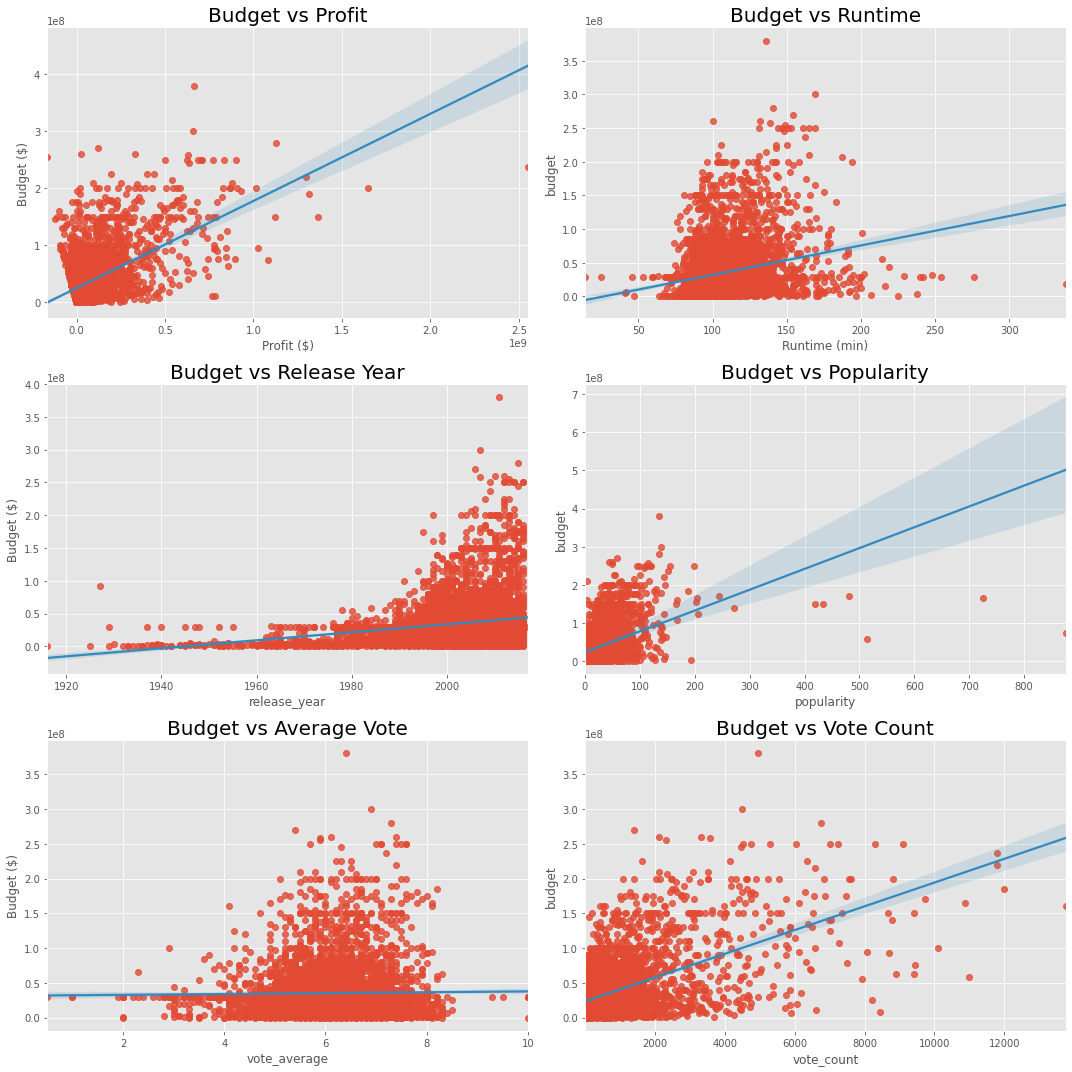

In [33]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))
p_color = dict(color="C0")
l_color = dict(color="C1")
sns.regplot(x="profit", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[0][0])
sns.regplot(x="runtime", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[0][1])
sns.regplot(x="release_year", y="budget", data = df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[1][0])
sns.regplot(x="popularity", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[1][1])
sns.regplot(x="vote_average", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[2][0])
sns.regplot(x="vote_count", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[2][1])

axarr[0][0].set_ylabel('Budget ($)', fontsize = 12)
axarr[0][0].set_xlabel('Profit ($)', fontsize = 12)
axarr[0][1].set_xlabel('Runtime (min)', fontsize = 12)
axarr[1][0].set_ylabel('Budget ($)', fontsize = 12)
axarr[2][0].set_ylabel('Budget ($)', fontsize = 12)

#Set title for each plot
axarr[0][0].set_title('Budget vs Profit', fontsize = 20)
axarr[0][1].set_title('Budget vs Runtime', fontsize = 20)
axarr[1][0].set_title('Budget vs Release Year', fontsize = 20)
axarr[1][1].set_title('Budget vs Popularity', fontsize = 20)
axarr[2][0].set_title('Budget vs Average Vote', fontsize = 20)
axarr[2][1].set_title('Budget vs Vote Count', fontsize = 20)
fig.tight_layout()

## Exploring Budget and Revenue with Respect to Datetime

In [34]:
#computes total revenue, profit, budget per release year
revenues = df.groupby('release_year')['revenue'].sum() 
budgets = df.groupby('release_year')['budget'].sum()
profits = df.groupby('release_year')['profit'].sum()
rate = df.groupby('release_year')['profit_rate'].mean()

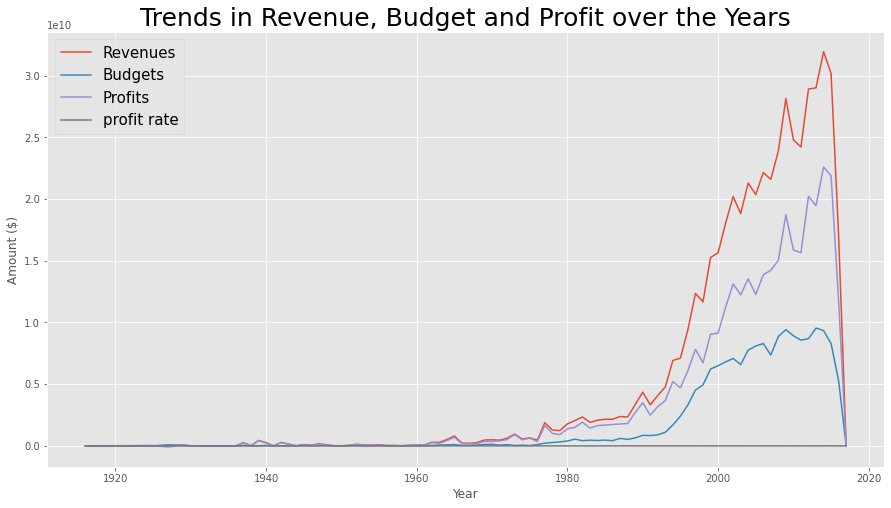

In [35]:
plt.figure(figsize=(15,8))
x1 = df['release_year']
y1 = revenues
# plotting the revenue points 
plt.plot(revenues, label = "Revenues")
# line 2 points
x2 = df['release_year']
y2 = budgets
# plotting the budgets points 
plt.plot(budgets, label = "Budgets")
x3 = df['release_year']
y3 = profits
# plotting the profits points
plt.plot(profits, label = "Profits")
x4 = df['release_year']
y4 = rate
plt.plot(rate,label='profit rate')

plt.xlabel('Year')
# Set the y axis label of the current axis.
plt.ylabel('Amount ($)')
# Set a title of the current axes.
plt.title('Trends in Revenue, Budget and Profit over the Years', fontsize =25)
# show a legend on the plot
plt.legend(loc='upper left', fontsize = 15)
# Display a figure.
plt.show()

Revenue margins sky-rocketed at the turn of the century. This could be attributed to
technological advancement in cinema, record viewership on several paid platforms like Netflix
etc.


There is an interesting consistency with increasing budget and revenue. This analysis exposes
the obvious budget/sales corollary as well as the improving revenue from movies with
increasing budget and time. The most tangible aspect of a movie’s budget is that the amount that distributors would pay for
a film is almost always calculated based on budget regardless of the script, the cast or anything
else. The higher the budget, the more the film sells for so there is a huge tendency to inflate the
cost of movies. This explains the almost certain increase in revenue with budget.

In [36]:
df['release_year'].max()

2017.0

In [37]:
last_10_years = df[df['release_year']>2007]

In [38]:
revenues = last_10_years.groupby('release_year')['revenue'].sum()
budgets = last_10_years.groupby('release_year')['budget'].sum()
profits = last_10_years.groupby('release_year')['profit'].sum()
rate = last_10_years.groupby('release_year')['profit_rate'].mean()

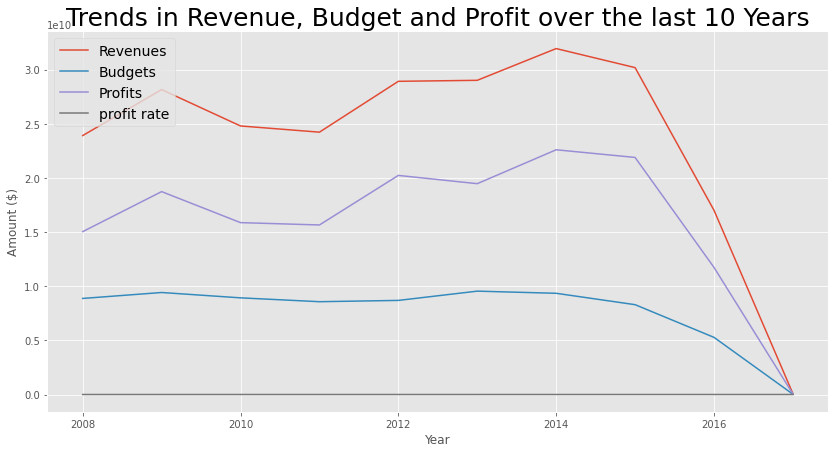

In [39]:
plt.figure(figsize=(14,7))
x1 = df['release_year']
y1 = revenues
# plotting the revenue points 
plt.plot(revenues, label = "Revenues")
# line 2 points
x2 = df['release_year']
y2 = budgets
# plotting the budgets points 
plt.plot(budgets, label = "Budgets")
x3 = df['release_year']
y3 = profits
# plotting the profits points
plt.plot(profits, label = "Profits")
x4 = df['release_year']
y4 = rate
plt.plot(rate,label='profit rate')

plt.xlabel('Year')
# Set the y axis label of the current axis.
plt.ylabel('Amount ($)')
# Set a title of the current axes.
plt.title('Trends in Revenue, Budget and Profit over the last 10 Years', fontsize =25)
# show a legend on the plot
plt.legend(loc='upper left', fontsize = 14)
# Display a figure.
plt.show()

From the graph Revenue
and profit had its peak in 2014 with
Revenue topping the chart with a
whopping 24.13 Billon dollars.

It is interesting to note that movies released over the years generaly make more than 100% return on investments. Movie business is a lucrative business.

**How many movies have grossed over $1 billion for each which year?**

In [40]:
billi_movies = df[df['revenue']>1000000000].sort_values('revenue', ascending =False)

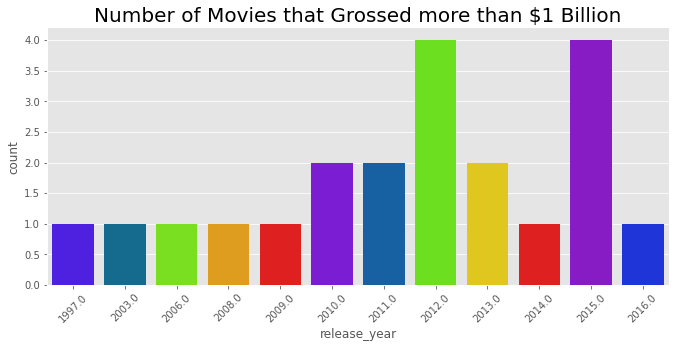

In [41]:
fig =sns.catplot(x='release_year', data=billi_movies, kind="count", palette = 'prism')
fig.set_xticklabels(rotation=45)
plt.title('Number of Movies that Grossed more than $1 Billion', fontsize = 20)
plt.gcf().set_size_inches(10, 4)

21 movies, all released between 1997 and 2016, grossed more that 1 billion. 1(Titanic) in 1997 with the
rest falling after 2003. 71.4%, representing 15 of the movies, were released between 2010 – 2015.

In [42]:
#compute total and avg revenue per month, quarter
monthly_revenue = df.groupby('release_month')['revenue'].sum().to_frame().reset_index()
avg_monthly_revenue =  df.groupby('release_month')['revenue'].mean().to_frame().reset_index()
quarterly_revenue = df.groupby('release_quarter')['revenue'].sum().to_frame().reset_index()
avg_quarterly_revenue =  df.groupby('release_quarter')['revenue'].mean().to_frame().reset_index()

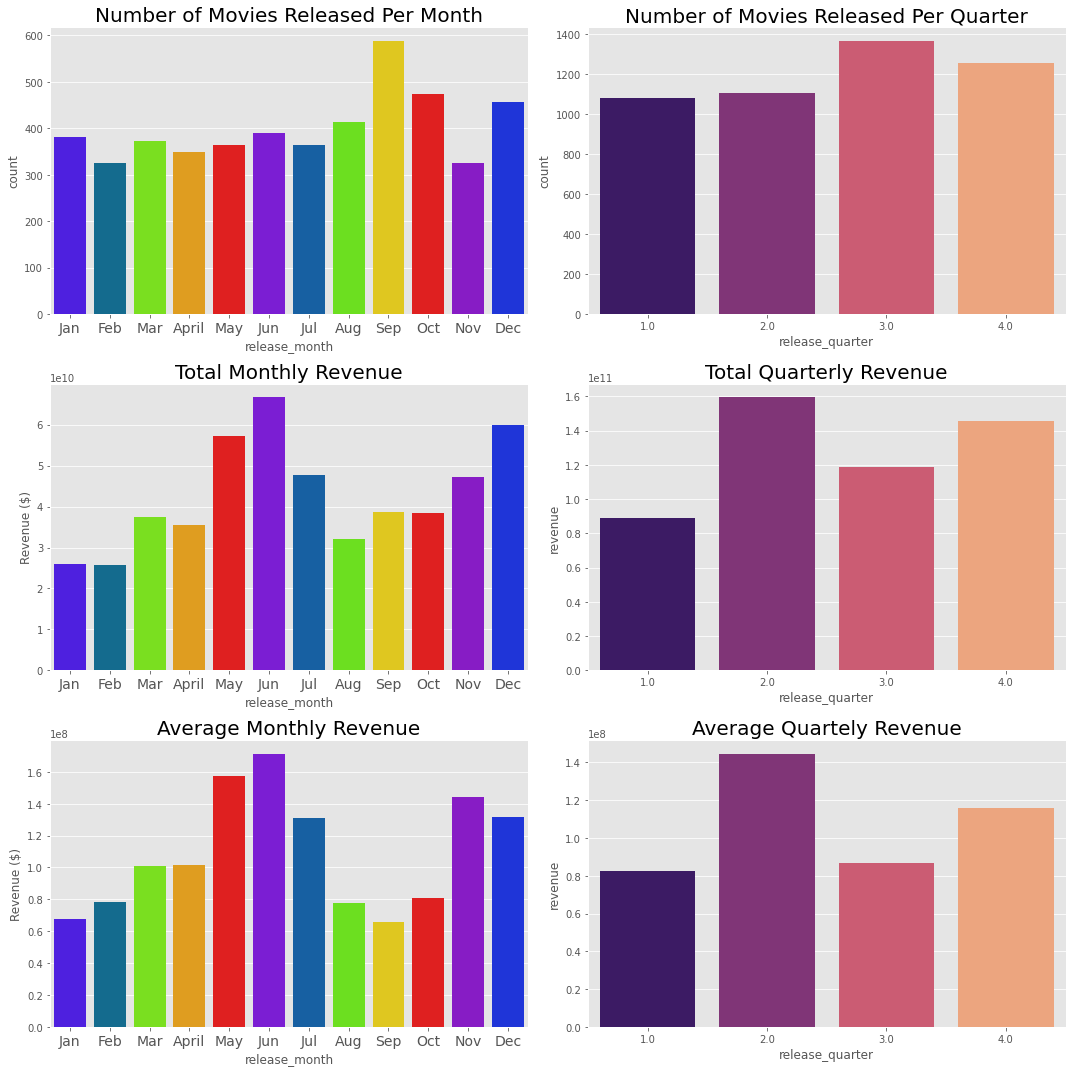

In [43]:
#Initiate subplots for different distribution of revenue by relese month
fig, axarr = plt.subplots(3,2, figsize=(15, 15))
sns.barplot(x='release_month', y = 'revenue', data = monthly_revenue, ax = axarr[1][0], palette = 'prism')
sns.countplot(df["release_month"], ax=axarr[0][0], palette='prism')
sns.barplot(x='release_month', y = 'revenue', data = avg_monthly_revenue, ax = axarr[2][0], palette = 'prism')
sns.barplot(x='release_quarter', y='revenue', data =avg_quarterly_revenue,ax =axarr[2][1],palette ='magma')
sns.countplot(df['release_quarter'], ax=axarr[0][1],palette ='magma')
sns.barplot(x='release_quarter', y = 'revenue', data = quarterly_revenue, ax = axarr[1][1],palette ='magma')

#set plot titles

axarr[2][0].set_title('Average Monthly Revenue', fontsize = 20)
axarr[0][0].set_title('Number of Movies Released Per Month', fontsize = 20)
axarr[1][0].set_title('Total Monthly Revenue', fontsize = 20)
axarr[0][1].set_title('Number of Movies Released Per Quarter',fontsize =20)
axarr[1][1].set_title('Total Quarterly Revenue',fontsize = 20)
axarr[2][1].set_title('Average Quartely Revenue',fontsize = 20)

axarr[1][0].set_ylabel('Revenue ($)', fontsize = 12)
axarr[2][0].set_ylabel('Revenue ($)', fontsize = 12)

#add customized labels to plots
labels = ['Jan', 'Feb', 'Mar','April', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
x =[axarr[0][0], axarr[1][0],axarr[2][0]]
for a in x:
    a.set_xticklabels(labels,fontsize = 14)

fig.tight_layout()

Revenues peaked at targeted months of the year where producers expect more movie audiences.
For distributors solely focused on box office profits and generating the quickest return on
investment, usually aim for the peak summer season of June and July while August is regarded
as a last resort for studios who do not complete shooting and editing on time. Here, schools are
closed, children are looking for entertainment and parents are also less fatigued as many take
vacations. With cinema halls full, producers make more money. The last half of the month of
May is also targeted in preparation for the coming holiday, albeit school being in session.
Producers and distributors who are marketing their blockbuster films for both revenues and
awards tend to target the winter months of November and December, which also includes the
holiday season. During this season, audiences seek epic award-worthy dramas, animation et al
in Cinemas and for home entertainment.

THE ABOVE ALSO APPLIES FOR THE BOXPLOT BELOW

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

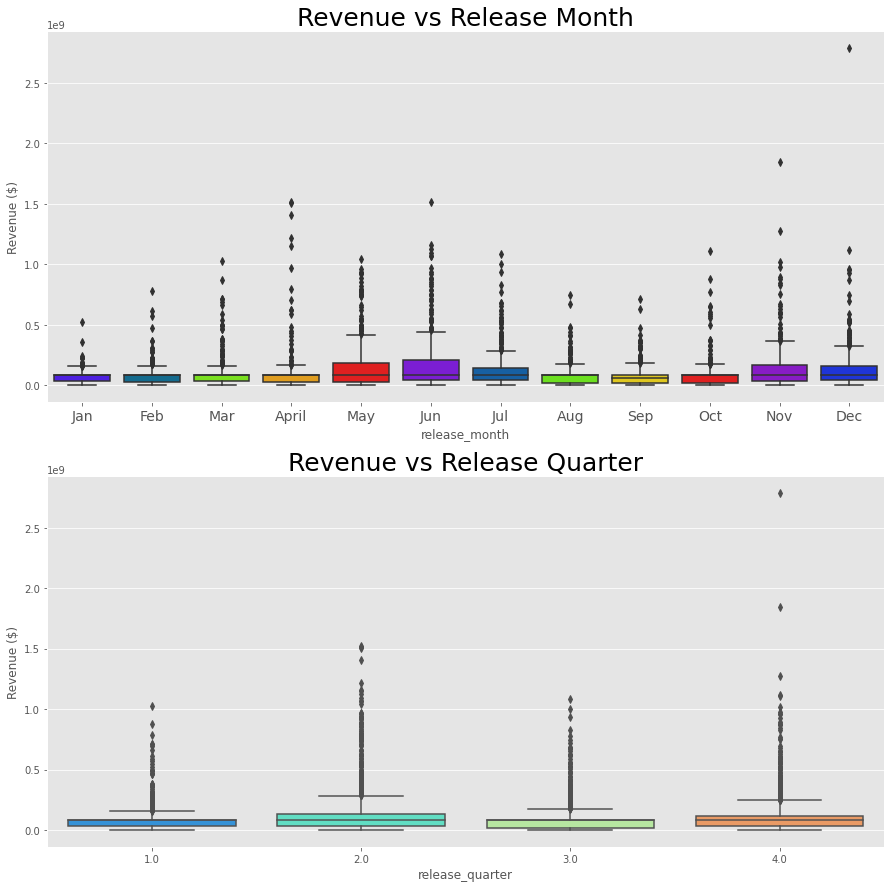

In [44]:
#Initiate subplots for different distribution of revenue by relese month
fig, axarr = plt.subplots(2,1, figsize=(15, 15))
sns.boxplot(x = 'release_month', y = 'revenue', data = df, ax = axarr[0], palette ='prism')
sns.boxplot(x = 'release_quarter', y = 'revenue', data = df, ax = axarr[1],palette ='rainbow')

axarr[0].set_title('Revenue vs Release Month', fontsize = 25)
axarr[1].set_title('Revenue vs Release Quarter',fontsize = 25)
axarr[0].set_ylabel('Revenue ($)', fontsize = 12)
axarr[1].set_ylabel('Revenue ($)', fontsize = 12)

axarr[0].set_xticklabels(labels,fontsize = 14)

## Exploring Movies

**Which movies have the highest ratings?**

we will need a metric score to rate our movie

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :

$$(\dfrac{v}{v+m}.R)+(\dfrac{m}{v+m}.C)$$
where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report
We already have v(vote_count) and R (vote_average) and C can be calculated as

In [45]:
C= movies['vote_average'].mean()
m= movies['vote_count'].quantile(0.9)


In [46]:
C

6.092171559442011

So, the mean rating for all the movies is approximately 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.



In [47]:
q_movies = df.copy().loc[df['vote_count'] >= m]
q_movies.shape

(481, 32)

In [48]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [49]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [50]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies according to IMDB rating
q_movies[['original_title','movie_director', 'vote_count', 'vote_average', 'score','release_year']].head(15)

,original_title,movie_director,vote_count,vote_average,score,release_year
1881,The Shawshank Redemption,Frank Darabont,8205.0,8.5,8.059258,1994.0
662,Fight Club,David Fincher,9413.0,8.3,7.939256,1999.0
65,The Dark Knight,Christopher Nolan,12002.0,8.2,7.920020,2008.0
3232,Pulp Fiction,Quentin Tarantino,8428.0,8.3,7.904645,1994.0
96,Inception,Christopher Nolan,13752.0,8.1,7.863239,2010.0
3337,The Godfather,Francis Ford Coppola,5893.0,8.4,7.851236,1972.0
95,Interstellar,Christopher Nolan,10867.0,8.1,7.809479,2014.0
809,Forrest Gump,Robert Zemeckis,7927.0,8.2,7.803188,1994.0
329,The Lord of the Rings: The Return of the King,Peter Jackson,8064.0,8.1,7.727243,2003.0
1990,The Empire Strikes Back,Irvin Kershner,5879.0,8.2,7.697884,1980.0


From the dataframe aboove, a significant number of the movies were released before the turn of the century, and most were released over 15 years ago. Becasue our formula for computing highly rated movies is reliant on number of votes, it is expected that older movies, on the average, will have higher number of votes than the newer ones since they have been around for a longer period of time. This might account for the high number of old movies on th top list.

#### Most popular and least popular movies

In [51]:
pop= df.sort_values('popularity', ascending=False)
pop_10 = pop.head(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Minions'),
  Text(0, 1, 'Interstellar'),
  Text(0, 2, 'Deadpool'),
  Text(0, 3, 'Guardians of the Galaxy'),
  Text(0, 4, 'Mad Max: Fury Road'),
  Text(0, 5, 'Jurassic World'),
  Text(0, 6, 'Pirates of the Caribbean: The Curse of the Black Pearl'),
  Text(0, 7, 'Dawn of the Planet of the Apes'),
  Text(0, 8, 'The Hunger Games: Mockingjay - Part 1'),
  Text(0, 9, 'Big Hero 6')])

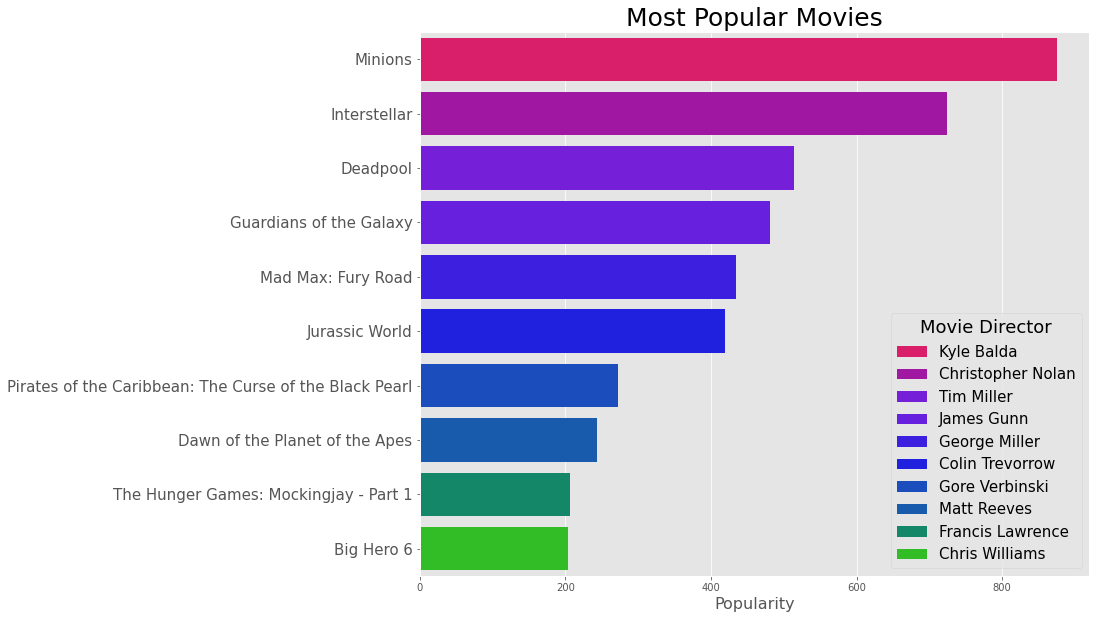

In [52]:
plt.figure(figsize=(12,10))

sns.barplot(y = 'original_title',x = 'popularity',data= pop_10,palette = 'prism', hue='movie_director', dodge = False)
#plt.gca().invert_yaxis()
plt.xlabel("Popularity", fontsize = 16)
plt.ylabel("") 
plt.title("Most Popular Movies", fontsize = 25)
plt.legend(title ='Movie Director',fontsize = 15).get_title().set_fontsize(18)
plt.yticks(fontsize= 15)

Just as the regression analysis has shown, we can see that none 15 highest rated movies are on the most popular list. This further reinforce the conclusion that popularity doesn't necessary means high rating.

In [53]:
least_10 = pop.tail(10)

Text(0.5, 1.0, 'Least Popular Movies')

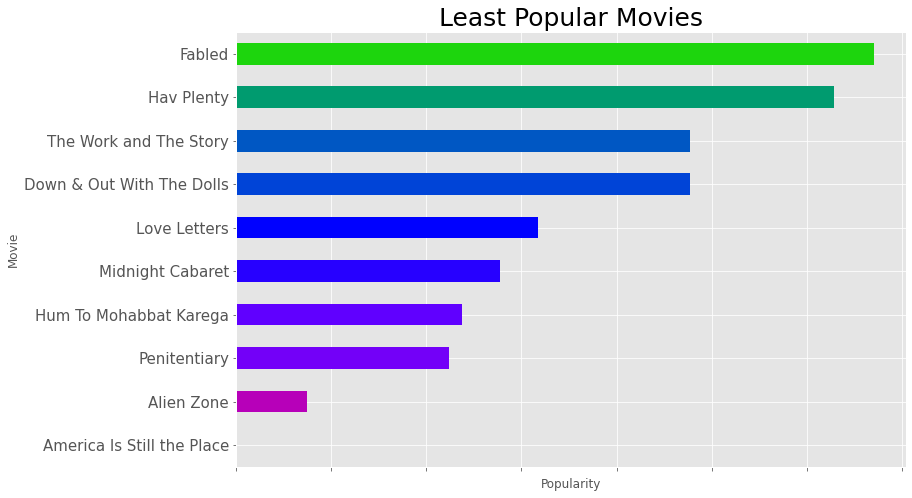

In [54]:
plt.figure(figsize=(12,8))

least_10.index = least_10.original_title.values
chart = least_10['popularity'].sort_values(ascending =True).plot.barh(color=sns.color_palette("prism",10), fontsize = 15)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_xlabel('Popularity')
chart.set_ylabel('Movie')
chart.set_title('Least Popular Movies', fontsize = 25)

**Big Budget Movies**

In [55]:
big_budget = df.sort_values('budget', ascending = False).iloc[:10]


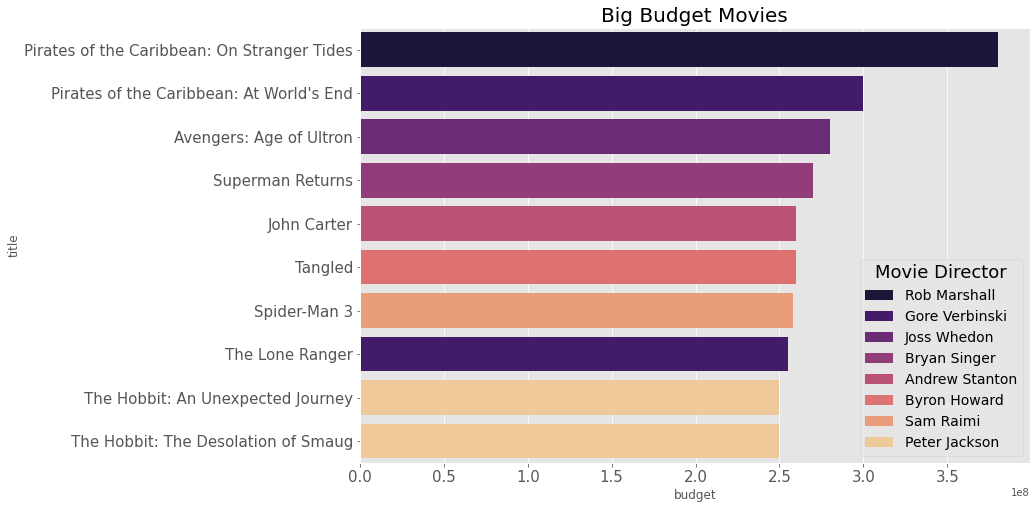

In [56]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'budget',
            y = 'title',
            palette='magma',
            data = big_budget,
           hue= 'movie_director',
           dodge = False)
plt.title('Big Budget Movies', fontsize = 20)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title ='Movie Director',fontsize = 14).get_title().set_fontsize(18)

plt.show()


The big budget movies unsurprisingly are of genres represented in the top 5 of “Top 10 Genres
by Average Budget”
Pirates of the Caribbean are of Fantasy/Adventure, Avengers(Action/Sci-fi), Superman
returns(Action/Adventure), John Carter(Sci-fi/Adventure), Tangled(Animation), Spiderman
3(Action/Adventure), The lone ranger (Action/Western) and The hobbit(Adventure/Fantasy)

### How many movies made profit or loss?

In [57]:
profit_movies = df[df['profit']>0]
loss_movies = df[df['profit']<0]
no_loss_profit = df[df['profit']==0]

In [58]:
len(profit_movies)

3894

In [59]:
len(loss_movies)

907

In [60]:
len(no_loss_profit)

2

#### Which movies made the highest profit and loss margins?

In [61]:
profit_loss = df[['original_title', 'release_year', 'profit']].sort_values('profit', ascending =False)

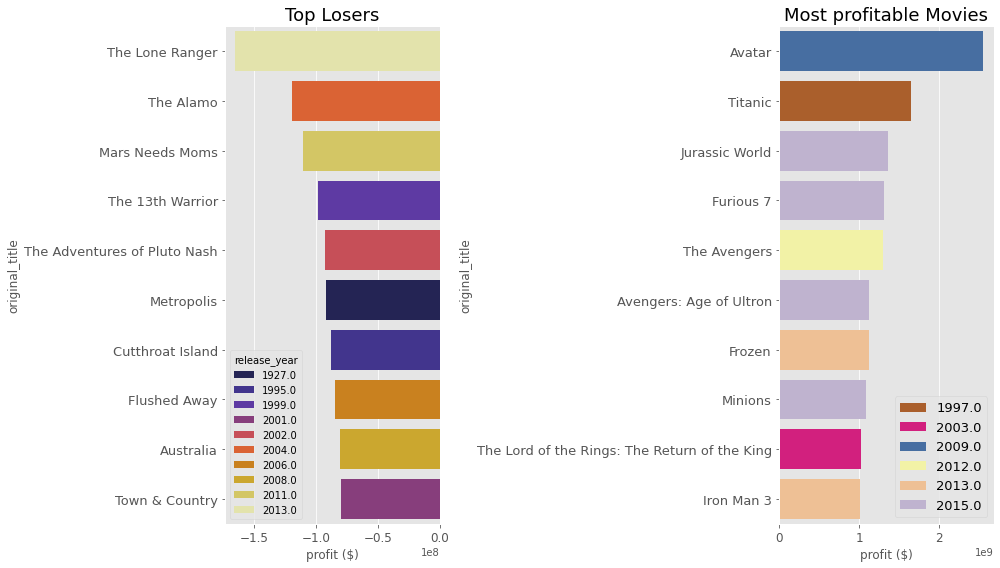

In [62]:
#Initiate subplots for different distribution of revenue by relese month
fig, axarr = plt.subplots(1,2, figsize=(14, 8))
sns.barplot(x = 'profit', y = 'original_title', data = profit_loss.head(10), ax = axarr[1], palette ='Accent_r', hue= 'release_year', dodge = False)
sns.barplot(x = 'profit', y = 'original_title', data = profit_loss.tail(10).sort_values('profit', 
                                                                ascending =True),hue = 'release_year', ax = axarr[0], palette = 'CMRmap', dodge = False)

axarr[1].set_title('Most profitable Movies', fontsize =18)
axarr[0].set_title('Top Losers',fontsize = 18)

axarr[0].set_xlabel('profit ($)', fontsize = 12)
axarr[1].set_xlabel('profit ($)', fontsize = 12)

axarr[0].tick_params(axis= 'y',labelsize =13)
axarr[1].tick_params(axis= 'y',labelsize =13)
axarr[0].tick_params(axis= 'x',labelsize =12)
axarr[1].tick_params(axis= 'x',labelsize =12)
axarr[1].legend(fontsize =13)
fig.tight_layout()

One common thing
to note in the movies with high
profit is that they are mostly
Adventure and Science Fiction movies.

## Exploring Crew and Cast Members

### Gender Distribution

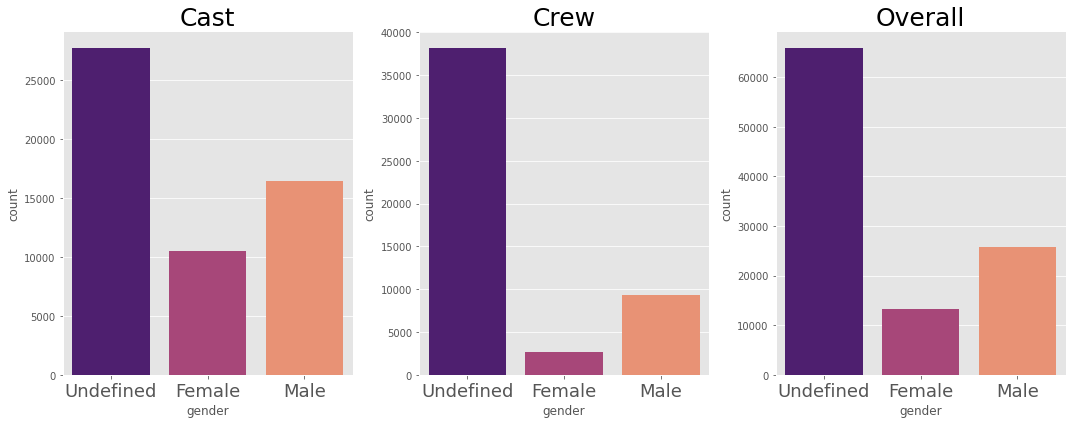

In [63]:
fig, axarr= plt.subplots(1, 3, figsize=(15, 6))
sns.countplot(people.drop_duplicates(["id"])[people["type"] == "cast"]["gender"], ax=axarr[0], palette = 'magma')
sns.countplot(people.drop_duplicates(["id"])[people["type"] == "crew"]["gender"], ax=axarr[1], palette = 'magma')
sns.countplot(people.drop_duplicates(["id"])["gender"], ax=axarr[2], palette = 'magma')
axarr[0].set_title("Cast", fontsize = 25)
axarr[1].set_title("Crew", fontsize = 25)
axarr[2].set_title("Overall", fontsize = 25)
for i in range(3):
    axarr[i].set_xticklabels(["Undefined", "Female", "Male"],fontsize = 18)
fig.tight_layout()

While there are more males than females in both cast and crew, the number of undefined gender, which might include non-binary gender conformists, is too high for us to conclude.

### Most prevalent jobs and departments among the crew members

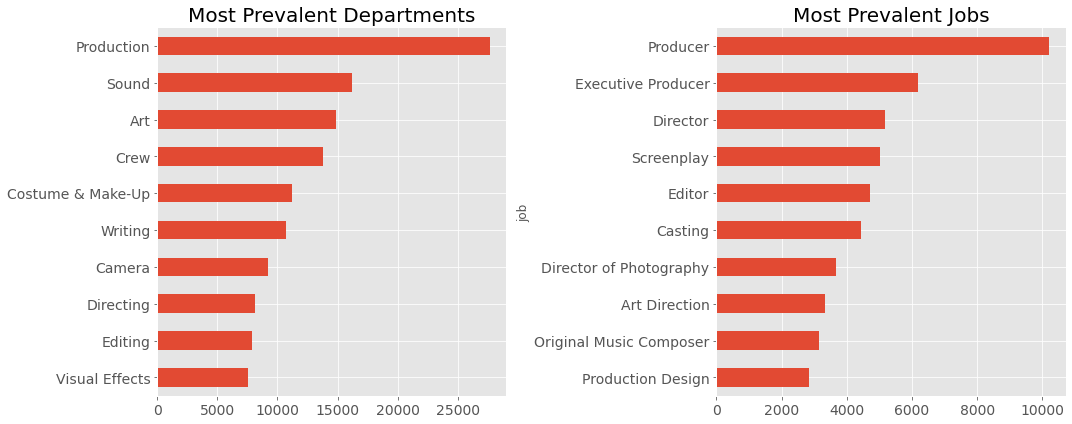

In [64]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))
people["department"].value_counts().sort_values().tail(10).plot.barh(ax=axarr[0], fontsize = 14)
people["job"].value_counts().sort_values(ascending = True).tail(10).plot.barh(ax=axarr[1], fontsize = 14)
axarr[1].set_ylabel("job")

axarr[0].set_title('Most Prevalent Departments', fontsize = 20)
axarr[1].set_title('Most Prevalent Jobs', fontsize = 20)

fig.tight_layout()

**Is there a relationship between crew size, cast size and budget?**

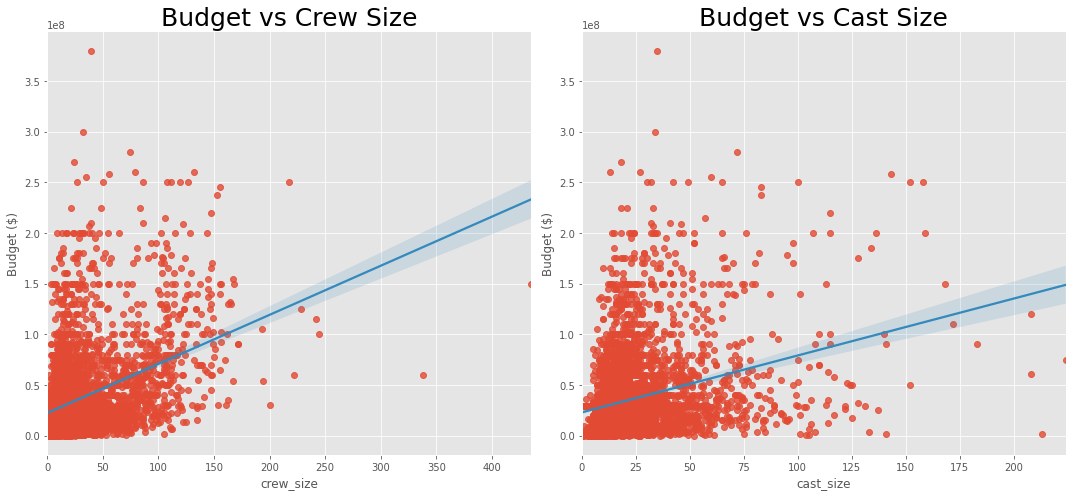

In [65]:
#Initiate subplot
fig, axarr = plt.subplots(1, 2, figsize=(15, 7))
p_color = dict(color="C0")
l_color = dict(color="C1")
sns.regplot(x="crew_size", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[0])
sns.regplot(x="cast_size", y="budget", data=df, fit_reg=True, scatter_kws=p_color, line_kws=l_color, ax=axarr[1])

axarr[0].set_ylabel('Budget ($)', fontsize = 12)
axarr[1].set_ylabel('Budget ($)', fontsize = 12)

#Set title for each plot
axarr[0].set_title('Budget vs Crew Size', fontsize = 25)
axarr[1].set_title('Budget vs Cast Size', fontsize = 25)
plt.tight_layout()

Both crew and cast size show positive correlation with budget. Indeed, large crew and cast size means more cost incurement. How large the cost becomes is subjected to the quality and status of the involved crew an casts.

Text(0.5, 1.0, 'Count of Cast and Crew Members')

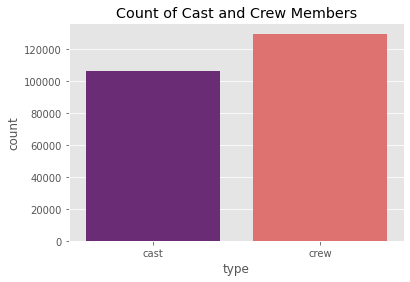

In [66]:
sns.countplot(people["type"], palette = 'magma')
plt.title('Count of Cast and Crew Members')

Over the years, the movie industry has had more people working as crew than cast. There are always more people working behind the scenes. This might explain why crew size has more positive effect on budget amount than cast size.However, to be able to understand, for instance, how people can easily get into the movie industry, we need the unique values for cast and crew. 

Text(0.5, 1.0, 'Unique Count of Cast and Crew Members')

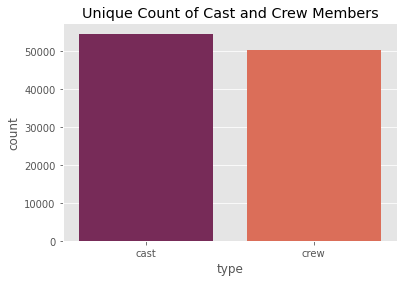

In [67]:
sns.countplot(people.drop_duplicates(["id"])["type"], palette = 'rocket')
plt. title('Unique Count of Cast and Crew Members')

On the unique level, there are actually more cast than crew. This shows that, over the years, more fresh individuals get into the movie industry as a cast member than as a crew member.

### Directors with highest number of movies

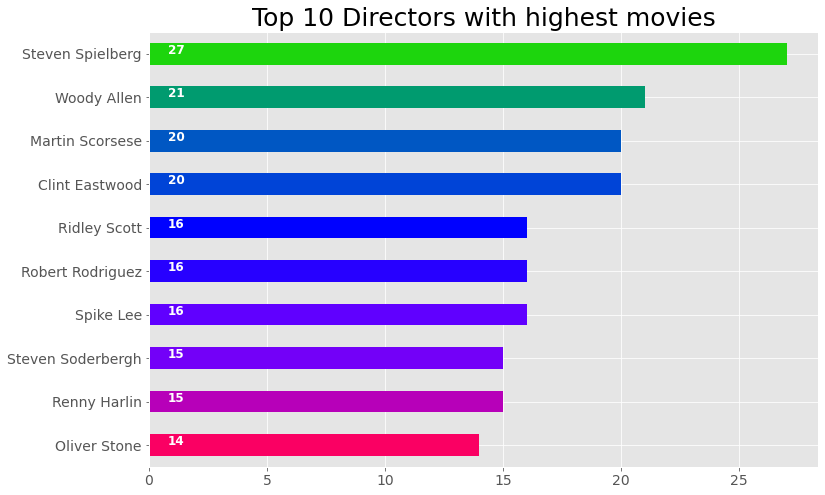

In [68]:
plt.subplots(figsize=(12,8))
ax = df['movie_director'].value_counts()[:10].sort_values(ascending=True). \
                            plot.barh(color=sns.color_palette("prism",10), fontsize = 14)

for i, v in enumerate(df['movie_director'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top 10 Directors with highest movies', fontsize = 25)
plt.show()

### Highest rated directors based on IMDB score

In [69]:
df['score'] = q_movies['score']

In [70]:
df.groupby('movie_director')['score'].mean().to_frame().sort_values('score', ascending=False).reset_index().iloc[:15]

,movie_director,score
0,Frank Darabont,7.800478
1,Irvin Kershner,7.697884
2,Damien Chazelle,7.633781
3,James Gunn,7.613005
4,Christopher Nolan,7.580831
5,Morten Tyldum,7.536150
6,Roger Allers,7.513840
7,Jonathan Demme,7.512362
8,Francis Ford Coppola,7.488760
9,Wes Anderson,7.448304


In [71]:
df.groupby('movie_director')['revenue'].mean().to_frame().reset_index().sort_values('revenue', ascending = False)

,movie_director,revenue
318,Chris Buck,1.274219e+09
1287,Kyle Balda,1.156731e+09
1311,Lee Unkrich,1.066970e+09
1177,Joss Whedon,9.879437e+08
332,Chris Renaud,8.759583e+08
...,...,...
175,Benedikt Erlingsson,1.100000e+01
1349,Louis Morneau,1.000000e+01
1782,Rachel Perkins,7.000000e+00
638,Eric Styles,7.000000e+00


In [72]:
cast_df = people[people['type']=='cast']

In [73]:
cast_df['name'].value_counts()

Samuel L. Jackson           67
Robert De Niro              57
Bruce Willis                51
Matt Damon                  48
Morgan Freeman              46
                            ..
Dougie Poynter               1
Ferdinand Schmidt-Modrow     1
Benjamin Plautz              1
Alison Chand                 1
Nelly                        1
Name: name, Length: 54201, dtype: int64

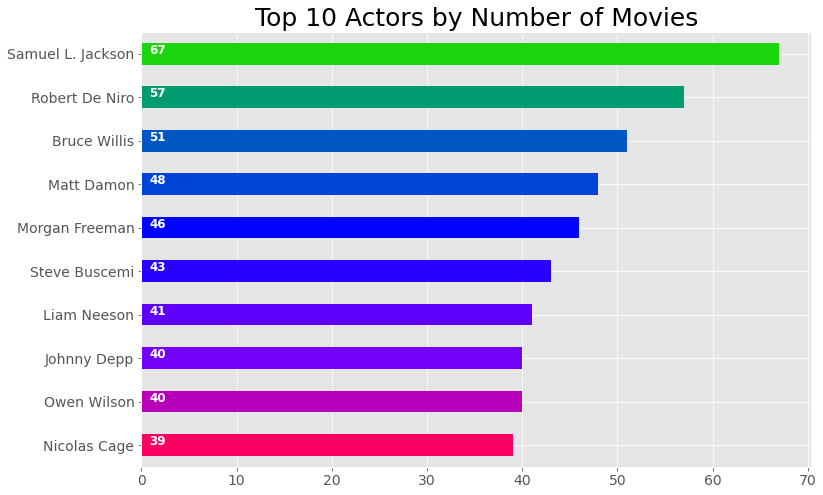

In [74]:
plt.subplots(figsize=(12,8))
ax = cast_df['name'].value_counts()[:10].sort_values(ascending=True). \
                            plot.barh(color=sns.color_palette("prism",10), fontsize = 14)

for i, v in enumerate(cast_df['name'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top 10 Actors by Number of Movies', fontsize = 25)
plt.show()

In [75]:
female_cast = people[(people['type']=='cast') & (people['gender']==1)]

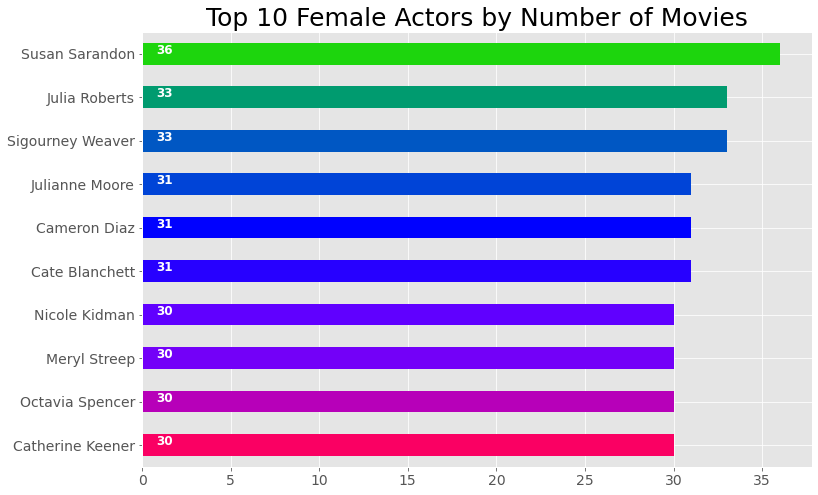

In [76]:
plt.subplots(figsize=(12,8))
ax = female_cast['name'].value_counts()[:10].sort_values(ascending=True). \
                            plot.barh(color=sns.color_palette("prism",10), fontsize = 14)

for i, v in enumerate(female_cast['name'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top 10 Female Actors by Number of Movies', fontsize = 25)
plt.show()

In [77]:
df['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
df['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
df['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))

In [78]:
df['actor_1_name'].value_counts()

Jennifer Aniston     15
Morgan Freeman       13
Samuel L. Jackson    12
Brad Pitt            12
Robert De Niro       11
                     ..
J. T. Walsh           1
Richard Basehart      1
Katrina Bowden        1
Nicholas D'Agosto     1
Mick Jagger           1
Name: actor_1_name, Length: 2720, dtype: int64

In [79]:
df['actor_2_name'].value_counts()

Cameron Diaz                9
Ed Harris                   9
Marisa Tomei                9
Emma Watson                 8
Samuel L. Jackson           8
                           ..
Eddie Redmayne              1
Kate Lynch                  1
Michael Kenneth Williams    1
Tracey Ullman               1
James Anderson              1
Name: actor_2_name, Length: 3095, dtype: int64

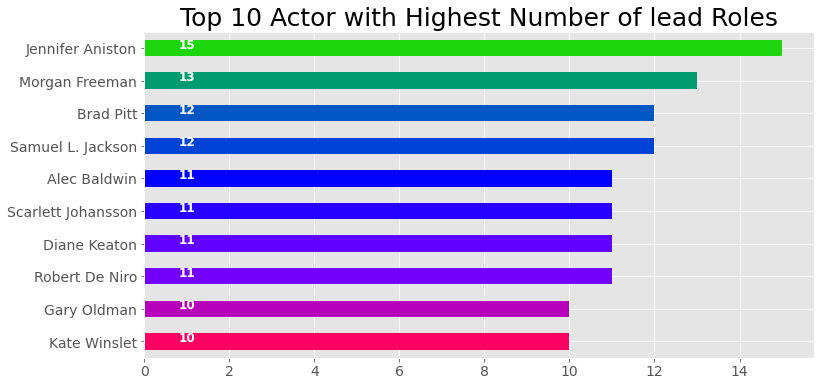

In [80]:
plt.subplots(figsize=(12,6))
ax =df['actor_1_name'].value_counts()[:10].sort_values(ascending=True). \
                            plot.barh(color=sns.color_palette("prism",10), fontsize = 14)

for i, v in enumerate(df['actor_1_name'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top 10 Actor with Highest Number of lead Roles', fontsize = 25)
plt.show()

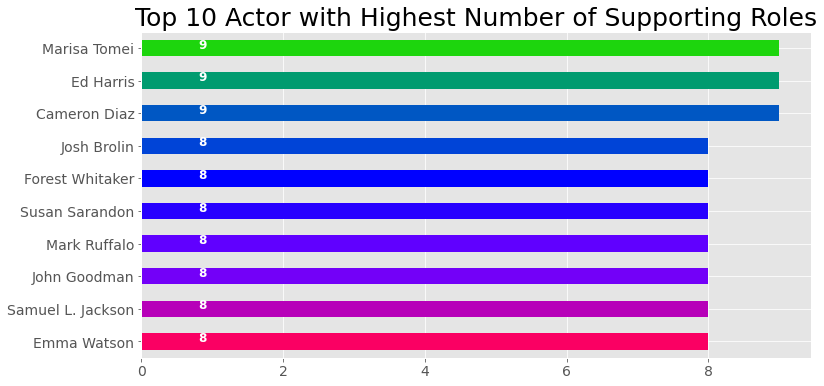

In [81]:
plt.subplots(figsize=(12,6))
ax =df['actor_2_name'].value_counts()[:10].sort_values(ascending=True). \
                            plot.barh(color=sns.color_palette("prism",10), fontsize = 14)

for i, v in enumerate(df['actor_2_name'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top 10 Actor with Highest Number of Supporting Roles', fontsize = 25)
plt.show()

## Exploring Genres

In [82]:
genres= []
movies["genres"].apply(lambda x: genres.extend(x))
genres = pd.DataFrame(genres)

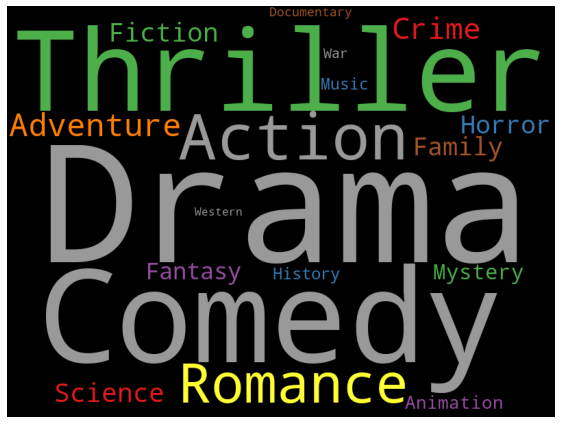

In [83]:
#create a wordcloud for the movie genries
genre_names = genres['name']

unique_string=(" ").join(genre_names)
wordcloud = WordCloud(collocations=False, prefer_horizontal = 1, width=800,
                        height=600,
                        min_font_size=14,
                        background_color='black',
                        colormap="Set1").generate(unique_string)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()

Before digging deeper into Genre Analysis, it should be noted that the analysis below is based on one assumption: The primary genre for each movie is the first genre on the list of genres for each movie. While this might be largely true for the dataset, further analysis of animated movies, for instance, showed that there are more animations in the dataset than those produced by our assumption. However, to have an idea of trends in genres with respect to revenue, budgets, profits and other numerical variables, it becomes imperative to ascribe a genre that best describes the movie, hence the idea of primary genre. 

Therefore, the genre analysis, at best, is an estimate.

In [84]:
frequent_genre =df['primary_genre'].value_counts().to_frame().reset_index().rename(columns ={'index':'Primary Genre', 'primary_genre':'Count'}) 

In [85]:
frequent_genre

,Primary Genre,Count
0,Drama,1207
1,Comedy,1042
2,Action,754
3,Adventure,339
4,Horror,300
5,Crime,195
6,Thriller,194
7,Animation,123
8,Fantasy,117
9,Romance,106


Text(0.5, 1.0, 'Top 10 Genres by Number of Movies')

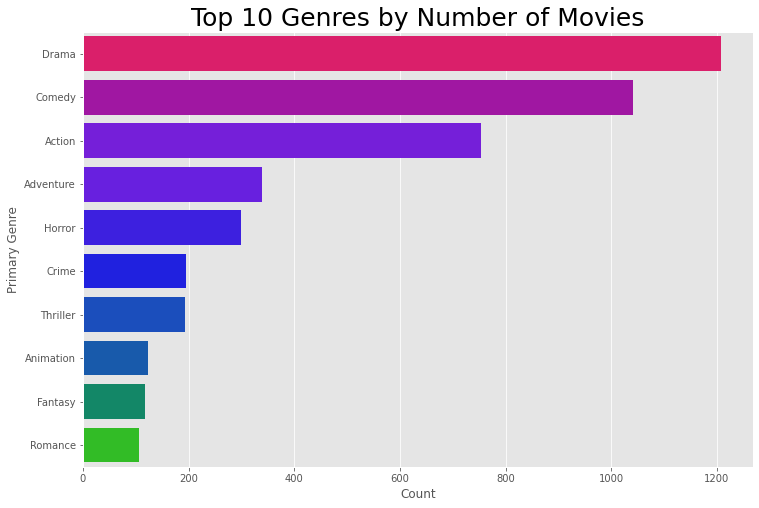

In [86]:
plt.figure(figsize=(12,8))
sns.barplot(y ='Primary Genre',x ='Count', data = frequent_genre.iloc[:10], palette = 'prism')
plt.title('Top 10 Genres by Number of Movies', fontsize = 25)

This is simply the genres of movies contained most in the dataset. Drama, comedy and action
are the dominant genres comprising of an astonishing 3003 movies and occupying a whopping
62.90% of the entire dataset.

In [87]:
popular_genre = df.groupby('primary_genre')[('popularity', 'budget', 'revenue')].mean().reset_index()

Text(0.5, 1.0, 'Top 10 Genres by Popularity of Movies')

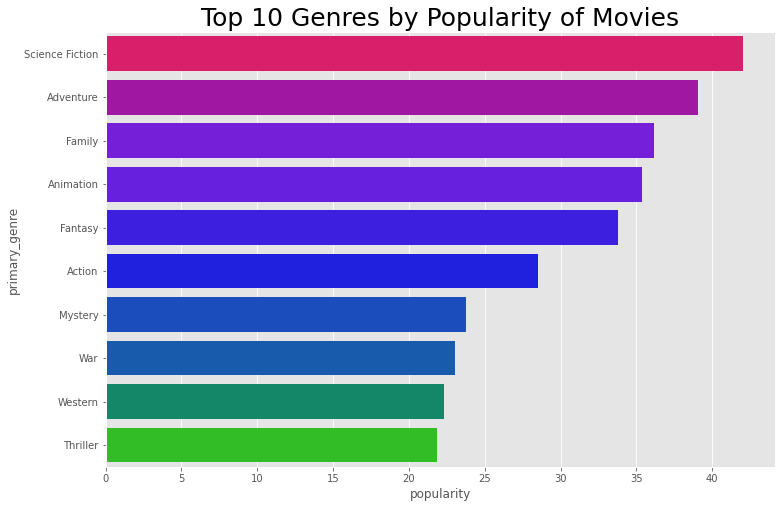

In [88]:
plt.figure(figsize=(12,8))
sns.barplot(y ='primary_genre',x ='popularity', data = popular_genre.sort_values(by='popularity',
                                                                   ascending = False).iloc[:10], palette = 'prism')
plt.title('Top 10 Genres by Popularity of Movies', fontsize = 25)

Despite the school of thought that the most popular brands of products are common, with movies,
the most popular genres depends more on population preferences. Here, Science Fiction emerged the
most popular genre despite having a seemingly infinitesimal value of 96 when compared to 1207
movies in Drama. Amongst the top three numerically dominant genres, only Action made it to
6th with Family and Adventure rounding up the top 3.

Text(0.5, 1.0, 'Top 10 Genres by Average Budget')

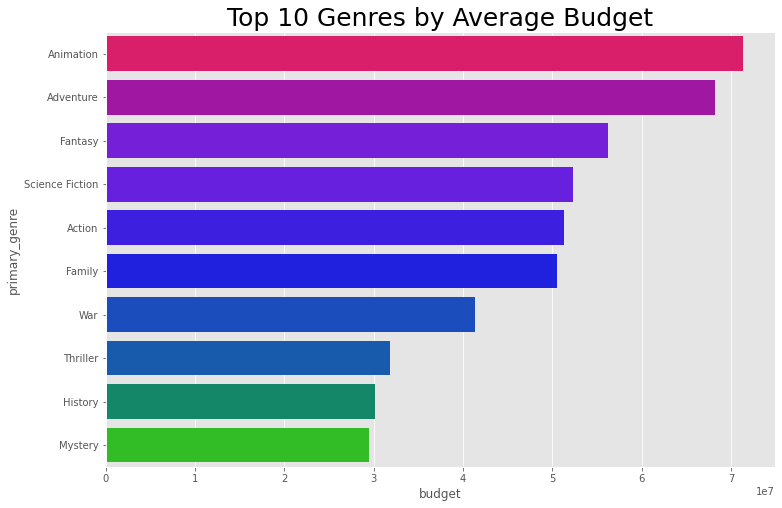

In [89]:
plt.figure(figsize=(12,8))
sns.barplot(y ='primary_genre',x ='budget', data = popular_genre.sort_values(by='budget', ascending = False).iloc[:10], palette = 'prism')
plt.title('Top 10 Genres by Average Budget', fontsize = 25)

Text(0.5, 1.0, 'Top 10 Genres by Average Revenue')

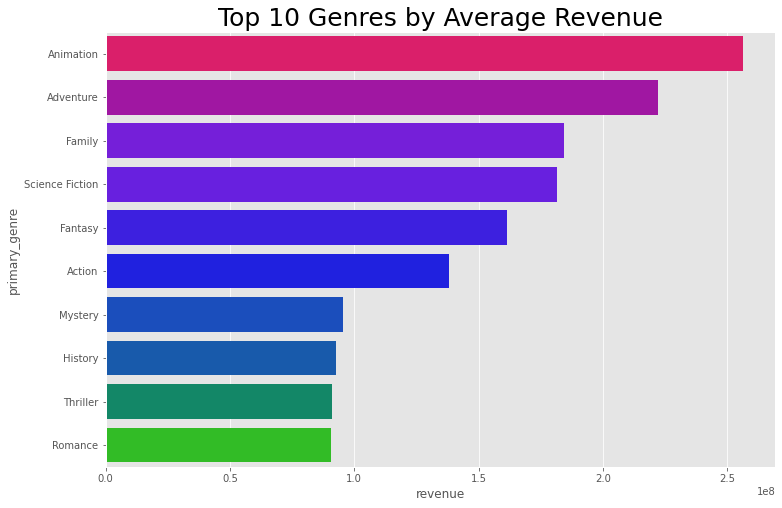

In [90]:
plt.figure(figsize=(12,8))
g = sns.barplot(y ='primary_genre',x ='revenue', data = popular_genre.sort_values(by='revenue', ascending = False).iloc[:10], palette = 'prism')
plt.title('Top 10 Genres by Average Revenue', fontsize = 25)

**whats the average runtime across top 5 most popular genres?**

In [91]:
genre_5 = df[(df['primary_genre']=='Animation')|(df['primary_genre']=='Adventure')|(df['primary_genre']=='Science Fiction')|(df['primary_genre']=='Family')|(df['primary_genre']=='Fantasy')]

In [92]:
genre_time = genre_5.groupby('primary_genre')['runtime'].mean().to_frame().reset_index().sort_values('runtime',ascending = False)

In [93]:
genre_time

,primary_genre,runtime
0,Adventure,113.061947
4,Science Fiction,109.031250
3,Fantasy,106.487179
2,Family,93.620566
1,Animation,89.552846


Adventure has the highest runtime with an average value of 113 minutes, followed closely by science fiction. Animation has the least average runtime.

### Wordcloud Analysis of Action Keywords According to Top  Genres

In [94]:
def get_df(column_name):
    frame = df[df['primary_genre']==column_name]
    keywords = frame.list_keywords.values.tolist()
    keywords = [x for i in keywords for x in i]
    wordcloud = WordCloud(collocations=False, width=800,
                        height=600,
                        min_font_size=14,
                        background_color='black',
                        colormap="Set1").generate(
    " ".join(keywords))
    plt.figure(figsize=(15,8))
    plt.axis('off')
    return plt.imshow(wordcloud)

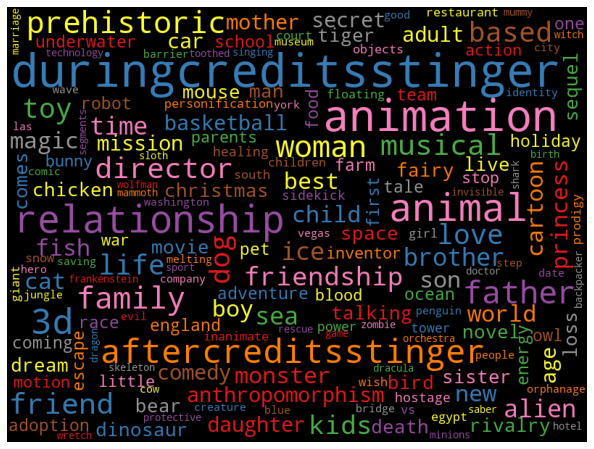

In [95]:
get_df('Animation')

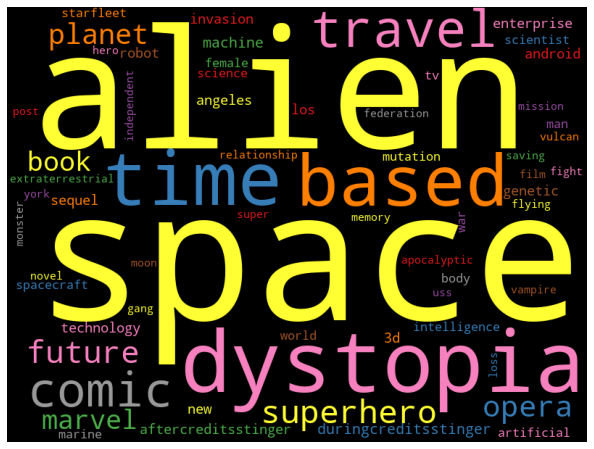

In [96]:
get_df('Science Fiction')

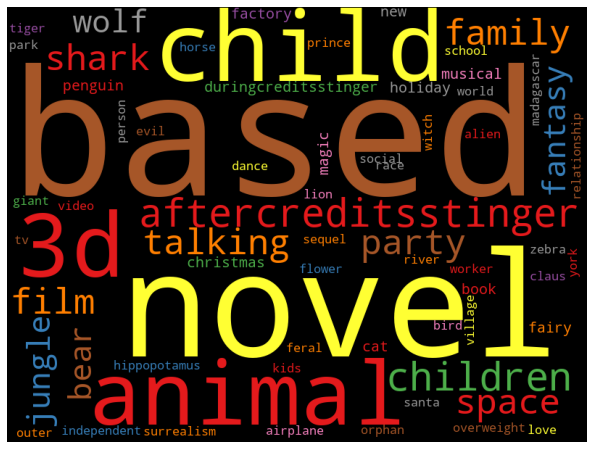

In [97]:
get_df('Family')

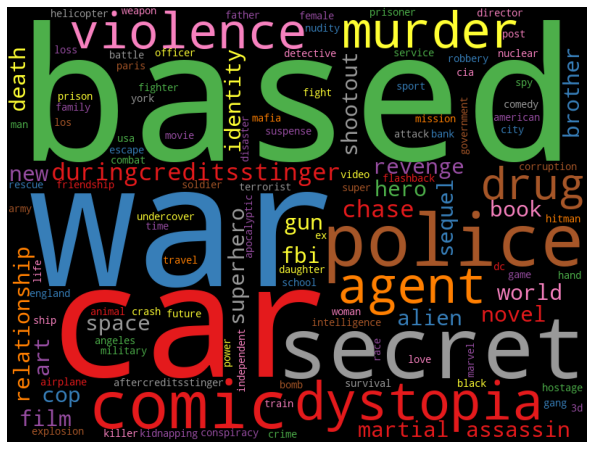

In [98]:
get_df('Action')

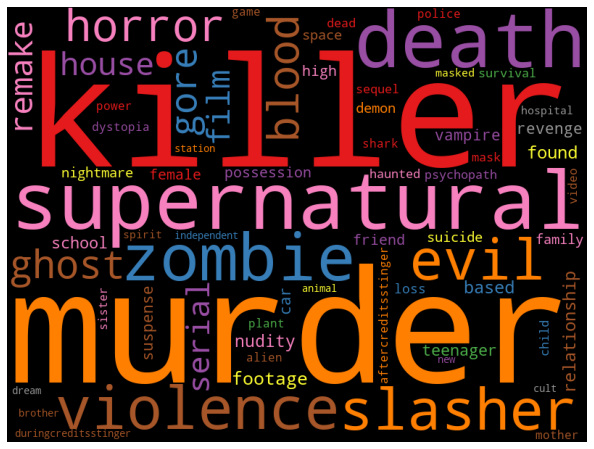

In [99]:
get_df('Horror')

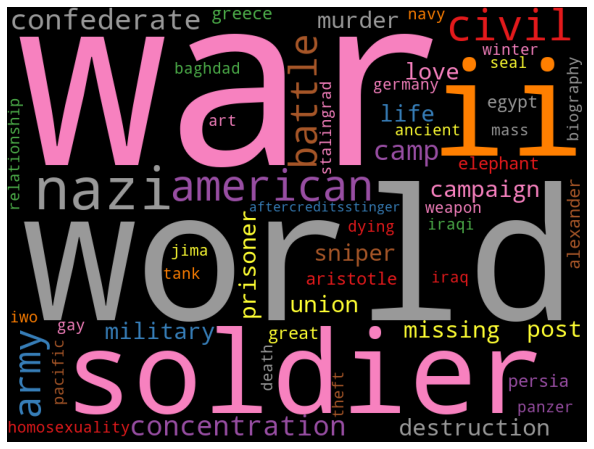

In [100]:
get_df('War')

Judging by the keywords that are used in describing movies in each genre, we can safely say that the primary genre ascribed to each movie by our assumption is fairly consistent with the movies.